# Imports and Defines

In [38]:
import io
import os
import torch
import zipfile
import requests
import numpy as np
import matplotlib.pyplot as plt

from torchvision import datasets
from torchvision import transforms
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Hyperparameters

In [2]:
IMAGE_SIZE = 512
EPOCHS = 5
LR = 0.01
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005
DROP_OUT_P = 0.2
BATCH_SIZE = 25


# Database Setups and Images Transforms

In [3]:
## TODO Taken from hw5 p4 refactor size 

BASE_PATH = './chest_xray/processed/'

db_train = datasets.ImageFolder(root=BASE_PATH+'train', transform=None)
db_val = datasets.ImageFolder(root=BASE_PATH+'val', transform=None)
db_test = datasets.ImageFolder(root=BASE_PATH+'test', transform=None)

img1, y1 = db_train[0]
img2, y2 = db_train[1]


print(img1.size, img1.mode, y1)
print(img2.size, img2.mode, y2)


(1857, 1317) RGB 0
(2031, 1837) RGB 0


In [4]:
db_train.transform = transforms.Compose([
    transforms.Grayscale(1),    
    transforms.RandomResizedCrop(size=[IMAGE_SIZE, IMAGE_SIZE], scale=(0.5,1.)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize(             # Normalize using ImageNet's mean and standard deviation
        mean=0.485,
        std=0.225
    )
])


db_val.transform = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize([IMAGE_SIZE, IMAGE_SIZE]),   
    # Resize the short side of the image to 256
    transforms.CenterCrop([IMAGE_SIZE, IMAGE_SIZE]),       # Crop a center patch of the image of size 224x224
    transforms.ToTensor(),            # Convert the image to tensor format
    transforms.Normalize(             # Normalize using ImageNet's mean and standard deviation
        mean= 0.406,
        std=0.225
    )
])

db_test.transform = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize([IMAGE_SIZE, IMAGE_SIZE]),           # Resize the short side of the image to 256
    transforms.CenterCrop([IMAGE_SIZE, IMAGE_SIZE]),       # Crop a center patch of the image of size 224x224
    transforms.ToTensor(),            # Convert the image to tensor format
    transforms.Normalize(             # Normalize using ImageNet's mean and standard deviation
        mean=0.485,
        std=0.229
    )
])

## Training and Testing Funcitons

In [36]:
from torch.utils.data import DataLoader
from torch import nn
import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def fit_one_epoch(model, opt, loader):
    model.train(True)
    loss = nn.CrossEntropyLoss()
    losses, accuracies = [], []
    for images, labels in tqdm.tqdm(loader):
        images = images.to(device)
        labels = labels.to(device)

        pred = model(images)
        l = loss(pred, labels)
        acc = (pred.argmax(1) == labels).float().mean()

        l.backward()
        opt.step()
        opt.zero_grad()

        losses.append(l.detach().item())
        accuracies.append(acc.detach().item())
    return np.mean(losses), np.mean(accuracies)


@torch.no_grad()
def eval(model, loader):
    model.train(False)
    loss = nn.CrossEntropyLoss()
    accuracies, losses = [], []
    all_preds, all_labels = [], []
    for images, labels in tqdm.tqdm(loader):
        images = images.to(device)
        labels = labels.to(device)

        pred = model(images)
        
        all_preds.extend(pred.argmax(1).cpu().tolist())
        all_labels.extend(labels.tolist())
        
        acc = (pred.argmax(1) == labels).float().mean()
        l = loss(pred, labels)

        accuracies.append(acc.detach().item())
        losses.append(l.detach().item())
    return np.mean(losses), np.mean(accuracies), all_preds, all_labels

@torch.no_grad()
def plot_cm(all_labels, all_preds):
    cm = confusion_matrix(all_labels, all_preds)

    # Plot
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='gray')
    plt.title("Confusion Matrix")
    plt.show()

    return cm

def fit(model, loader_train, loader_val, epochs=50, opt=None):
    assert opt is not None
    hist_tr_loss, hist_val_loss, hist_tr_acc, hist_val_acc = [], [], [], []
    for epoch in range(epochs):
        tr_l, tr_acc = fit_one_epoch(model, opt, loader_train)
        val_l, val_acc = eval(model, loader_val)

        print(f"Finished epoch {epoch} of {epochs}: Train Loss = {tr_l:.3f}  Val Loss = {val_l:.3f}   Train Acc = {tr_acc:.3f}   Val Acc = {val_acc:.3f}", flush=True)
        hist_tr_loss.append(tr_l)
        hist_val_loss.append(val_l)
        hist_tr_acc.append(tr_acc)
        hist_val_acc.append(val_acc)
    return hist_tr_loss, hist_val_loss, hist_tr_acc, hist_val_acc


def plot_training_history(hist_tr_loss, hist_val_loss, hist_tr_acc, hist_val_acc):
    plt.subplot(1, 2, 1)
    plt.plot(hist_tr_acc, label='train accuracy')
    plt.plot(hist_val_acc, label='val accuracy')
    plt.ylim([0.4, 1.05])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(hist_tr_loss, label='train loss')
    plt.plot(hist_val_loss, label='val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

## Model

In [6]:
model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=(5, 5), padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
    nn.Conv2d(32, 64, kernel_size=(3, 3)),
    nn.ReLU(),
    
    torch.nn.Dropout(p=DROP_OUT_P, inplace=False),
    
    nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
    nn.Conv2d(64, 64, kernel_size=(3, 3)),
    nn.ReLU(),
    
    nn.Flatten(),
    nn.Linear(1000000, 2) ## Binary Classifier
)

In [7]:
## TODO None sequential version for making variable lengths 

class CNN(nn.Module):
    def __init__(
        self, 
        convs,
        max_pools,
        hidden_depth=10, 
        num_classes=2
    ):
        super().__init__()
        self.flatten = nn.Flatten()

        layers = []
        # input/first hidden
        layers.append(nn.Conv2d(
            convs[0]['in_channels'],
            convs[0]['out_channels'], 
            kernel_size=convs[0]['kernal_size'], 
            padding=convs[0]['padding']
        ))
        
        # additional hidden layers - the one input
        for i in range(1, hidden_depth - 1):
            layers.append(nn.MaxPool2d(
                kernel_size=max_pools[i]['kernal_size'], 
                padding=max_pools[i]['padding']
            ))
            
            layers.append(nn.Conv2d(
                convs[i]['in_channels'],
                convs[i]['out_channels'], 
                kernel_size=convs[i]['kernal_size'], 
                padding=convs[i]['padding']
            ))              

        ## come up with automated way to calcualte falttened size
        self.hidden_layers = nn.ModuleList(layers)
        self.out = nn.Linear(..., num_classes)

    def forward(self, x):
        for layer in self.hidden_layers:
            x = self.activation(layer(x))
        
        x = self.flatten(x)
        return self.out(x)


## Fitting the Model

In [8]:
loader_train = DataLoader(db_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
loader_val = DataLoader(db_val, batch_size=BATCH_SIZE, shuffle=False)
loader_test = DataLoader(db_test, batch_size=BATCH_SIZE, shuffle=False)

model = model.to(device)

opt = torch.optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

hist_tr_loss, hist_test_loss, hist_tr_acc, hist_test_acc = fit(model, loader_train, loader_val, epochs=EPOCHS, opt=opt)

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:27<00:00,  1.29it/s]

Finished epoch 0 of 5: Train Loss = 0.582  Val Loss = 0.357   Train Acc = 0.728   Val Acc = 0.856



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:18<00:00,  1.94it/s]

Finished epoch 1 of 5: Train Loss = 0.438  Val Loss = 0.493   Train Acc = 0.799   Val Acc = 0.794



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:19<00:00,  1.88it/s]

Finished epoch 2 of 5: Train Loss = 0.447  Val Loss = 0.381   Train Acc = 0.802   Val Acc = 0.844



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:19<00:00,  1.87it/s]

Finished epoch 3 of 5: Train Loss = 0.410  Val Loss = 0.353   Train Acc = 0.818   Val Acc = 0.849



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:19<00:00,  1.88it/s]

Finished epoch 4 of 5: Train Loss = 0.407  Val Loss = 0.350   Train Acc = 0.817   Val Acc = 0.846


## Learning and Validation

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:16<00:00,  2.15it/s]


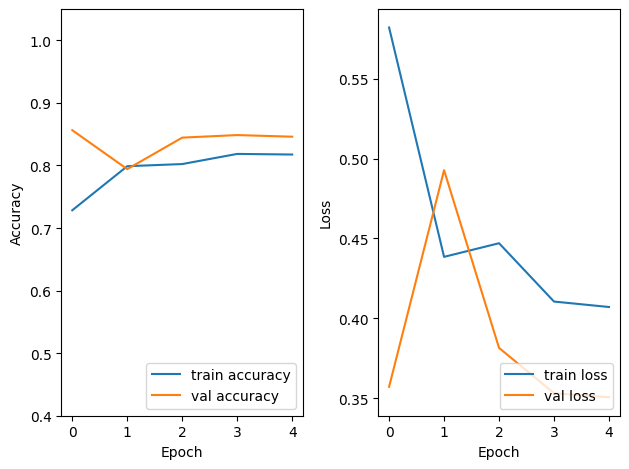

Test accuracy: 89.31%
Test loss: 0.276


In [27]:
l, acc, all_labels, all_preds = eval(model, loader_test)
plot_training_history(hist_tr_loss, hist_test_loss, hist_tr_acc, hist_test_acc)
print(f'Test accuracy: {acc*100:.2f}%')
print(f'Test loss: {l:.3f}')

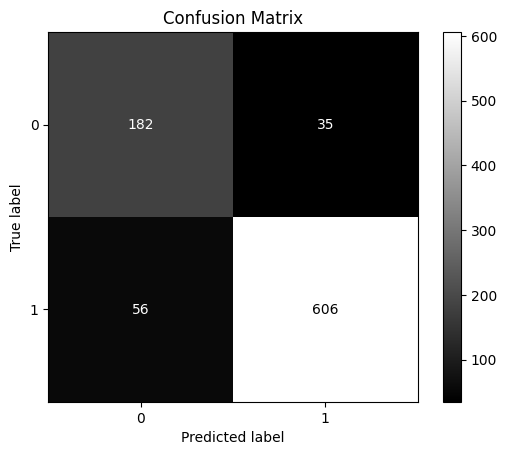

[[182  35]
 [ 56 606]]


In [39]:
cm = plot_cm(all_labels, all_preds)
print(cm)